In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from anomaly.modeling import *
from anomaly.utils import resample_ts, label_anomaly, visualize_anomaly
from predictor.utils import make_dataset
from predictor.trainer import DeepAntTrainer
from predictor.model import DeepAntModel

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, lr_scheduler
import torch

# Import Datasets

In [ ]:
nyc_taxi = pd.read_csv('/content/drive/MyDrive/TimeSeries/nyc_taxi.csv')
temp_fail = pd.read_csv('/content/drive/MyDrive/TimeSeries/machine_temperature_system_failure.csv')
temp_fail.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


# Preprocessing

Let's resample our data

In [ ]:
nyc_taxi = resample_ts(nyc_taxi, freq="12h")
temp_fail = resample_ts(temp_fail, freq="6h", method="mean")

Now, we are going to transform timestamp to datetime type and add the anomaly points. \
You can get the anomaly point [here](https://github.com/numenta/NAB/blob/master/labels/combined_windows.json).

In [ ]:
anomaly_points_temp_fail = [
        ["2013-12-10 06:25:00.000000", "2013-12-12 05:35:00.000000"],
        ["2013-12-15 17:50:00.000000", "2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000", "2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000", "2014-02-09 14:05:00.000000"]
]
anomaly_points_nyc_taxi = [
        ["2014-10-30 15:30:00.000000", "2014-11-03 22:30:00.000000"],
        ["2014-11-25 12:00:00.000000", "2014-11-29 19:00:00.000000"],
        ["2014-12-23 11:30:00.000000", "2014-12-27 18:30:00.000000"],
        ["2014-12-29 21:30:00.000000", "2015-01-03 04:30:00.000000"],
        ["2015-01-24 20:30:00.000000", "2015-01-29 03:30:00.000000"]
]

# Add anomaly points
# Nyc Taxi
nyc_taxi = label_anomaly(nyc_taxi, anomaly_points_nyc_taxi)
# Temperature Failure Machine
temp_fail = label_anomaly(temp_fail, anomaly_points_temp_fail)

## Visualization

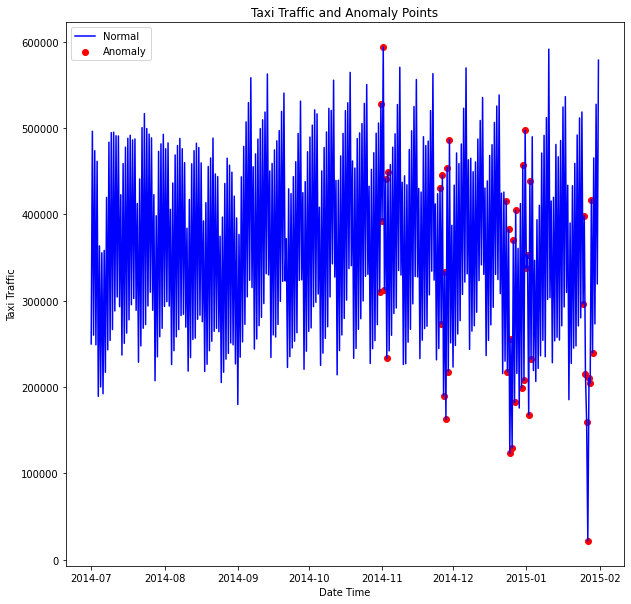

In [ ]:
visualize_anomaly(nyc_taxi, 'Taxi Traffic', 'Taxi Traffic and Anomaly Points')

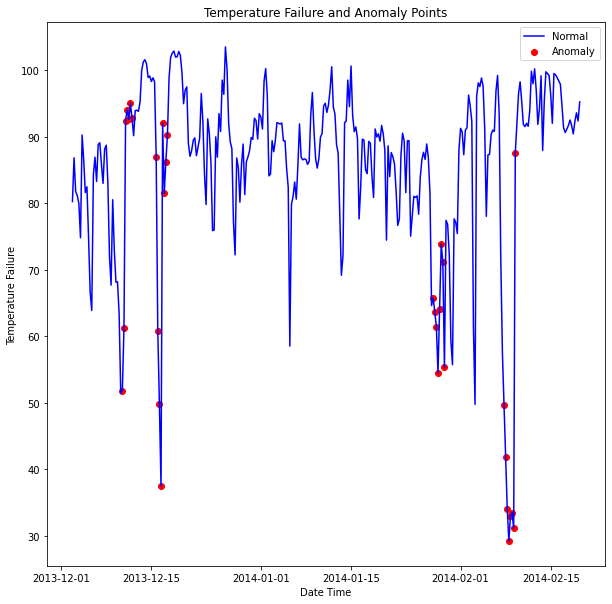

In [ ]:
visualize_anomaly(temp_fail, 'Temperature Failure', 'Temperature Failure and Anomaly Points')

# Anomaly Detection

## Hotteling 

For NYC Taxi : F1 Score = 0.163265306122449


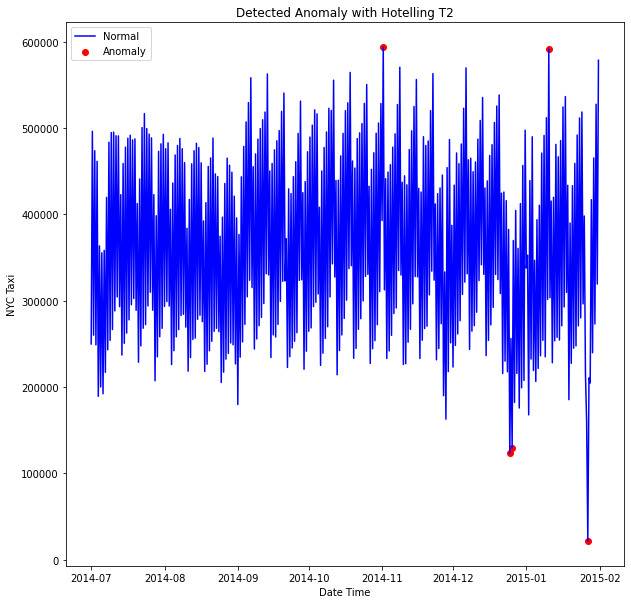

In [ ]:
sum_up_anomaly(get_anomaly_hotelling, nyc_taxi)

For Temperature Failure : F1 Score = 0.4897959183673469


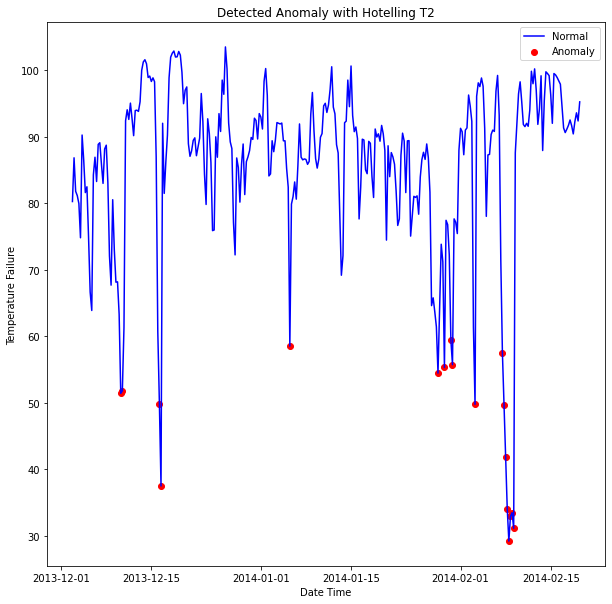

In [ ]:
sum_up_anomaly(get_anomaly_hotelling, temp_fail, data_name="Temperature Failure")

## One-Class SVM

For NYC Taxi : F1 Score = 0.203125


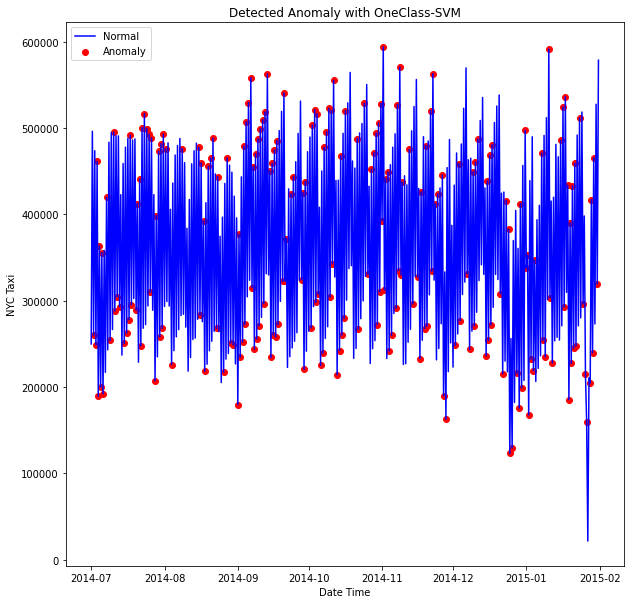

In [ ]:
sum_up_anomaly(get_anomaly_OCsvm, nyc_taxi, model_name='OneClass-SVM')

For Temperature Failure : F1 Score = 0.3870967741935484


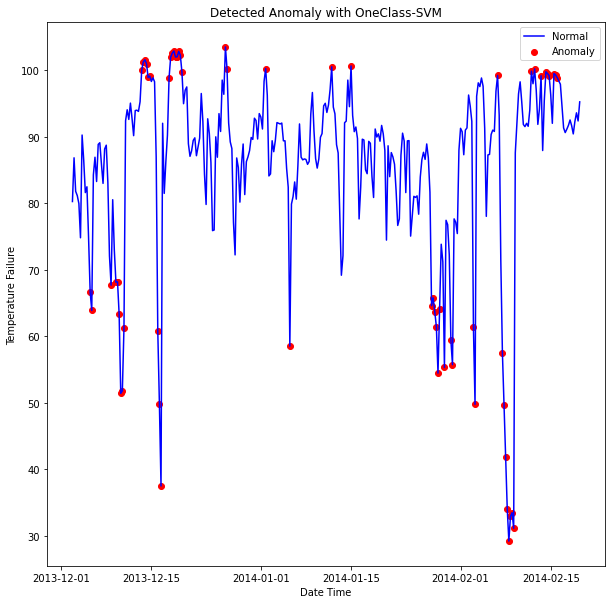

In [ ]:
sum_up_anomaly(get_anomaly_OCsvm, temp_fail, data_name="Temperature Failure", model_name='OneClass-SVM')

## Isolation Forest

For NYC Taxi : F1 Score = 0.2758620689655172


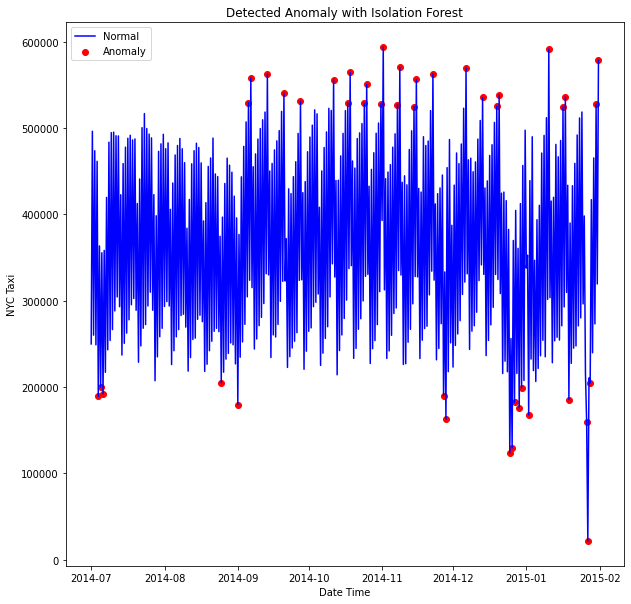

In [ ]:
sum_up_anomaly(get_anomaly_isolationforest, nyc_taxi, model_name="Isolation Forest")

For Temperature Failure : F1 Score = 0.5714285714285715


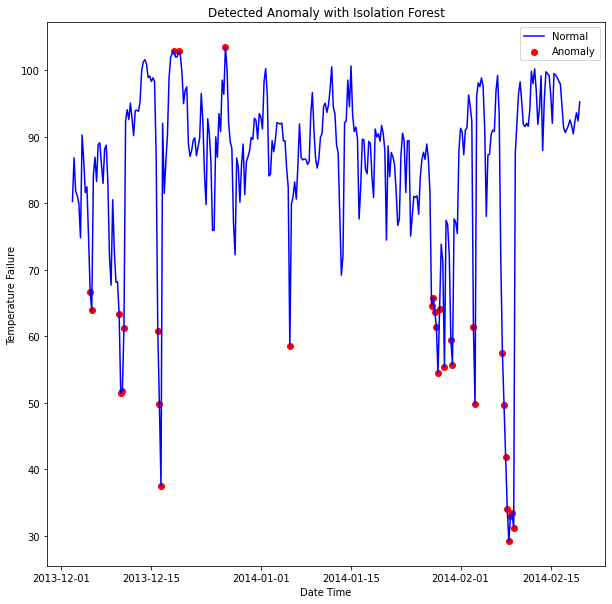

In [ ]:
sum_up_anomaly(get_anomaly_isolationforest, temp_fail, data_name="Temperature Failure", model_name="Isolation Forest")

## LOF

For NYC Taxi : F1 Score = 0.2758620689655172


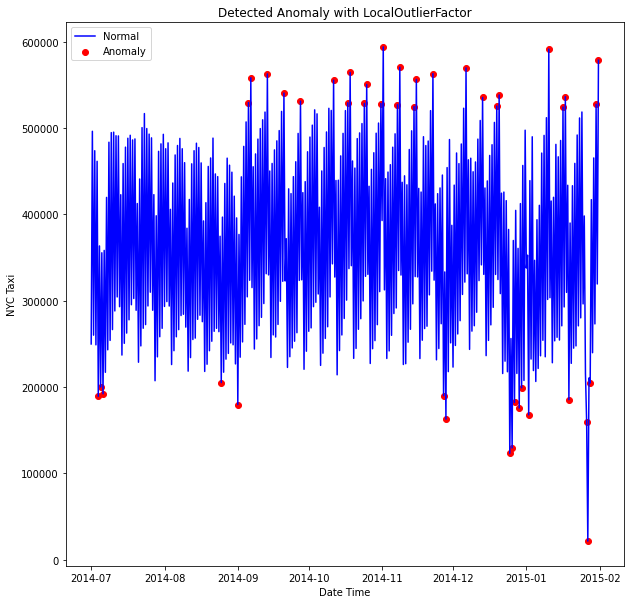

In [ ]:
sum_up_anomaly(get_anomaly_LOF, nyc_taxi, model_name="LocalOutlierFactor")

For NYC Taxi : F1 Score = 0.5714285714285715


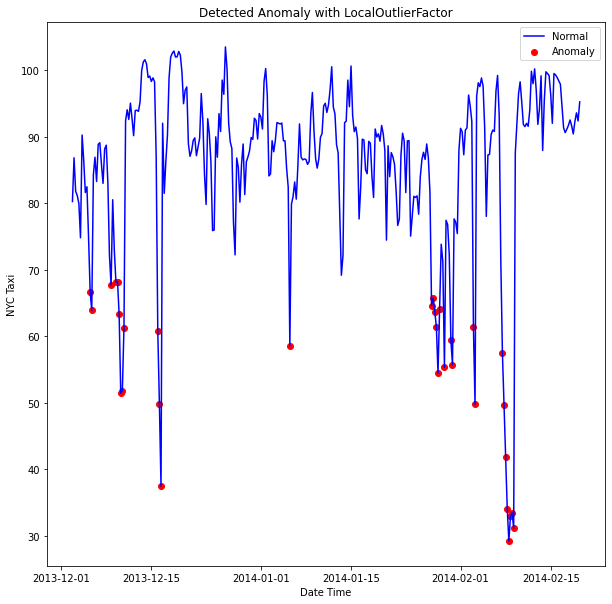

In [ ]:
sum_up_anomaly(get_anomaly_LOF, temp_fail, model_name="LocalOutlierFactor")

## Variance Based Method

For NYC Taxi : F1 Score = 0.24657534246575347


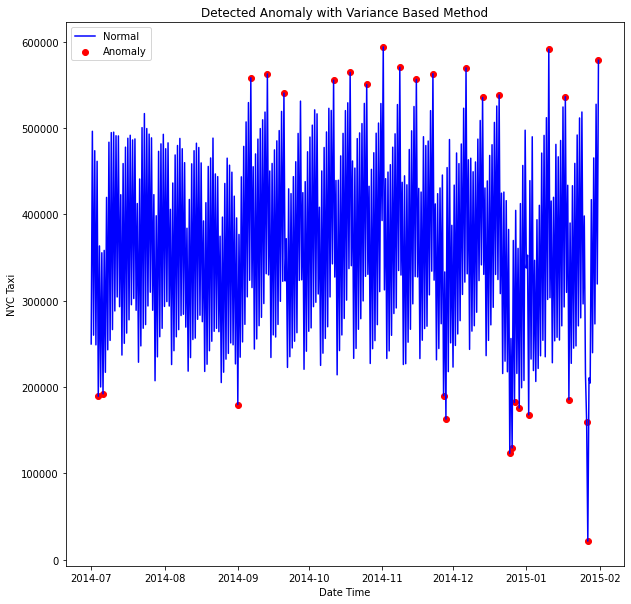

In [ ]:
sum_up_anomaly(get_anomaly_VARBM, nyc_taxi, model_name='Variance Based Method')

For Temperature Failure : F1 Score = 0.6101694915254238


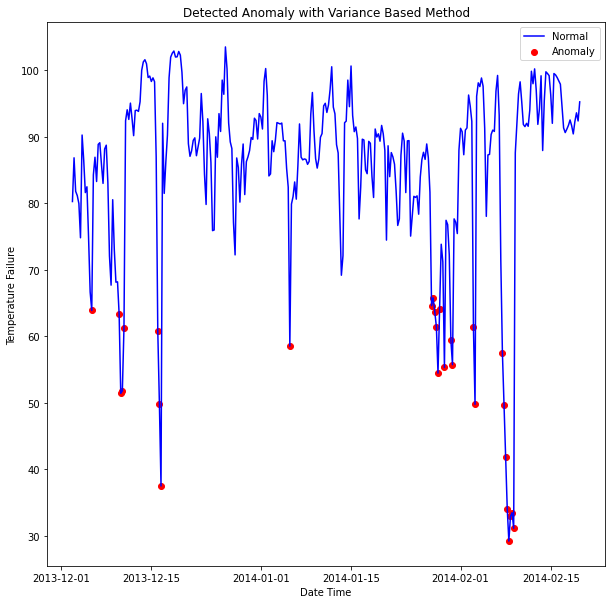

In [ ]:
sum_up_anomaly(get_anomaly_VARBM, temp_fail, data_name="Temperature Failure", model_name='Variance Based Method')

## FBProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


For NYC Taxi : F1 Score = 0.4301075268817204


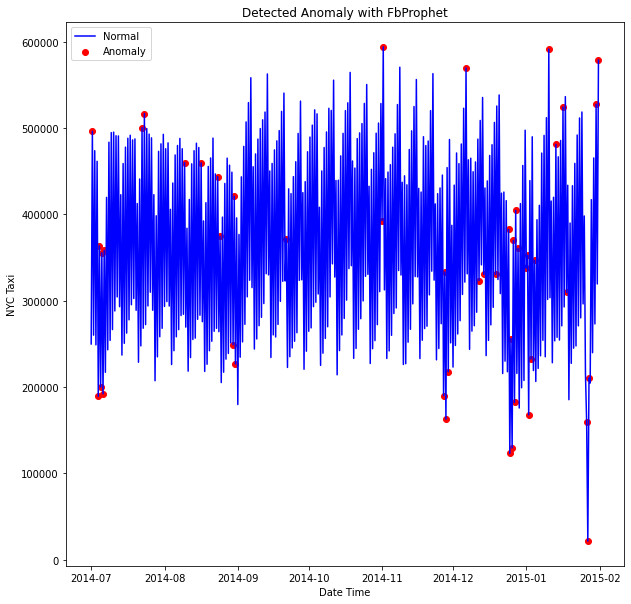

In [ ]:
sum_up_anomaly(get_anomaly_prophet, nyc_taxi, model_name="FbProphet")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


For Temperature Failure : F1 Score = 0.5757575757575757


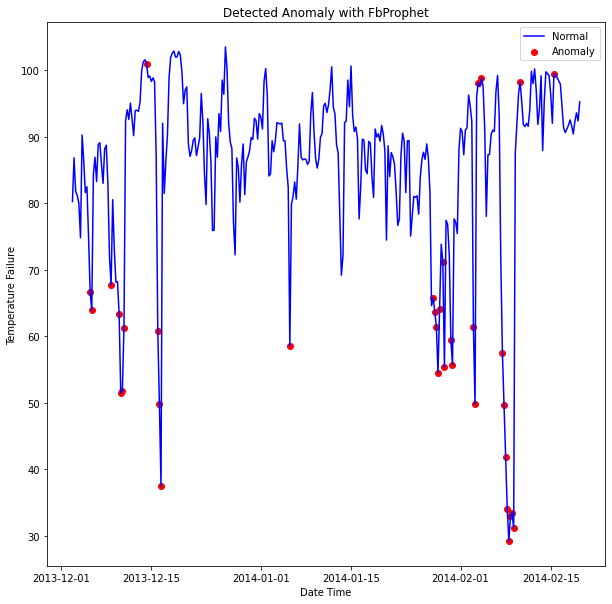

In [ ]:
sum_up_anomaly(get_anomaly_prophet, temp_fail, data_name="Temperature Failure", model_name="FbProphet")

## DeepAnt

### First Approach Training on All The Data

In [ ]:
X_train, y_train, train_set = make_dataset(nyc_taxi, ['value'], 5, 1)
train_data = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
test_data = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
model = DeepAntModel(5, 1, True)
model.cuda()
loss = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.05)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.7)
trainer = DeepAntTrainer(model, optimizer, scheduler, loss, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
trainer.fit(150, train_loader, test_loader)

For Nyc Taxi : F1 Score = 0.23255813953488372


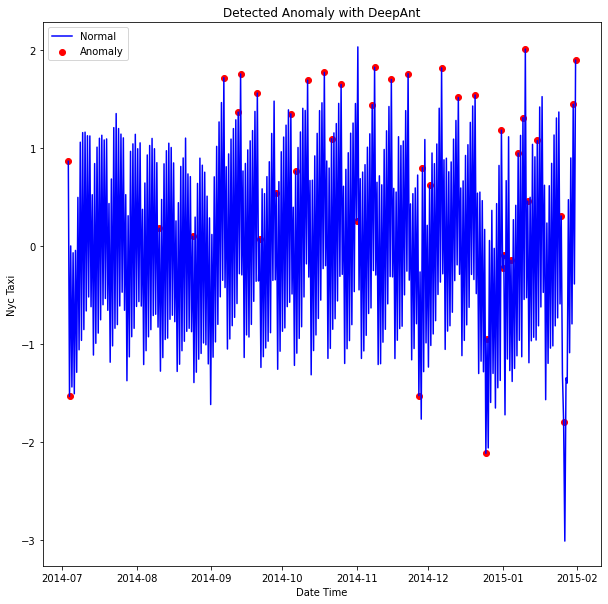

In [ ]:
y_pred = trainer.predict(test_loader, y_train.shape[0], 16)
sum_up_anomaly(get_anomaly_deepant, nyc_taxi[5:], 'Nyc Taxi',  'DeepAnt', y_pred, y_train)

In [ ]:
X_train, y_train, train_set = make_dataset(temp_fail, ['value'], 5, 1)
train_data = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
test_data = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
model = DeepAntModel(5, 1, True)
model.cuda()
loss = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.05)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.7)
trainer = DeepAntTrainer(model, optimizer, scheduler, loss, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
trainer.fit(150, train_loader, test_loader)

Epoch [1/150], TrainLoss: 0.9469, TestLoss: 0.7023, Learning rate = 0.05
Epoch [11/150], TrainLoss: 0.4760, TestLoss: 0.3791, Learning rate = 0.05
Epoch [21/150], TrainLoss: 0.3900, TestLoss: 0.3829, Learning rate = 0.034999999999999996
Epoch [31/150], TrainLoss: 0.3878, TestLoss: 0.3395, Learning rate = 0.034999999999999996
Epoch [41/150], TrainLoss: 0.4270, TestLoss: 0.3283, Learning rate = 0.034999999999999996
Epoch [51/150], TrainLoss: 0.4190, TestLoss: 0.2965, Learning rate = 0.034999999999999996
Epoch [61/150], TrainLoss: 0.3569, TestLoss: 0.3859, Learning rate = 0.034999999999999996
Epoch [71/150], TrainLoss: 0.3287, TestLoss: 0.2942, Learning rate = 0.034999999999999996
Epoch [81/150], TrainLoss: 0.2968, TestLoss: 0.3156, Learning rate = 0.024499999999999997
Epoch [91/150], TrainLoss: 0.2633, TestLoss: 0.3497, Learning rate = 0.024499999999999997
Epoch [101/150], TrainLoss: 0.3034, TestLoss: 0.2322, Learning rate = 0.01715
Epoch [111/150], TrainLoss: 0.2931, TestLoss: 0.2368, L

For Temp Fail : F1 Score = 0.41935483870967744


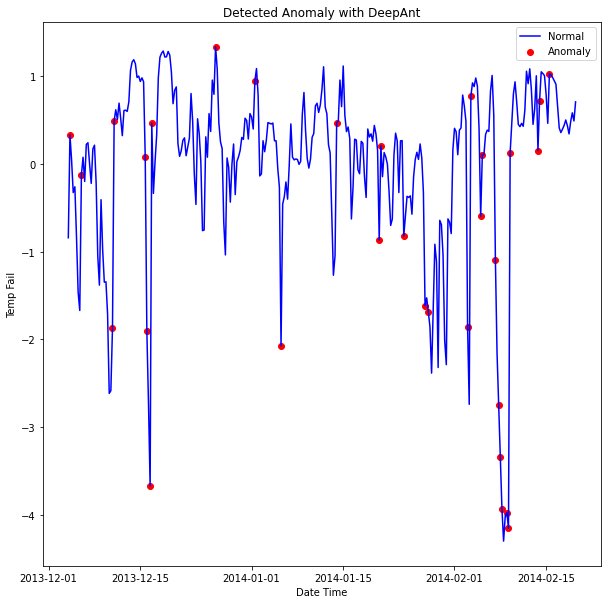

In [ ]:
y_pred = trainer.predict(test_loader, y_train.shape[0], 16)
sum_up_anomaly(get_anomaly_deepant, temp_fail[5:], 'Temp Fail',  'DeepAnt', y_pred, y_train)

### Second Approach : Testing Windows

In [ ]:
X, y, _ = make_dataset(nyc_taxi, ['value'], 5, 1, scale=True)

In [ ]:
split_indices = np.arange(0, len(X)+1, int(len(X)/5))
train_split = list()
test_split = list()
indices_total = np.arange(0, len(X))
for i in range(len(split_indices)-1):
  start, end = split_indices[i], split_indices[i+1]
  indices_test = list(np.arange(start, end))
  indices_train = list(set(indices_total) - set(indices_test))
  xtrain = X[indices_train]
  xtest = X[indices_test]
  ytrain = y[indices_train]
  ytest = y[indices_test]
  train_split.append((xtrain, ytrain))
  test_split.append((xtest, ytest))

In [ ]:
predictions = []
for train, test in zip(train_split, test_split):
  X_train, y_train = train
  X_test, y_test = test
  train_data = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
  test_data = TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))
  train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
  model = DeepAntModel(5, 1, True)
  model.cuda()
  loss = nn.MSELoss()
  optimizer = SGD(model.parameters(), lr=0.05)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.7)
  trainer = DeepAntTrainer(model, optimizer, scheduler, loss, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
  trainer.fit(150, train_loader, test_loader)
  y_pred = trainer.predict(test_loader, y_test.shape[0], 16)
  predictions.append(y_pred)

Epoch [1/150], TrainLoss: 0.5518, TestLoss: 0.1062, Learning rate = 0.05
Epoch [11/150], TrainLoss: 0.1806, TestLoss: 0.1265, Learning rate = 0.05
Epoch [21/150], TrainLoss: 0.1477, TestLoss: 0.0900, Learning rate = 0.05
Epoch [31/150], TrainLoss: 0.1339, TestLoss: 0.0547, Learning rate = 0.034999999999999996
Epoch [41/150], TrainLoss: 0.1317, TestLoss: 0.0426, Learning rate = 0.024499999999999997
Epoch [51/150], TrainLoss: 0.1240, TestLoss: 0.0683, Learning rate = 0.024499999999999997
Epoch [61/150], TrainLoss: 0.1021, TestLoss: 0.0748, Learning rate = 0.01715
Epoch [71/150], TrainLoss: 0.1177, TestLoss: 0.0467, Learning rate = 0.012004999999999998
Epoch [81/150], TrainLoss: 0.1037, TestLoss: 0.0596, Learning rate = 0.012004999999999998
Epoch [91/150], TrainLoss: 0.1093, TestLoss: 0.0508, Learning rate = 0.008403499999999998
Epoch [101/150], TrainLoss: 0.0942, TestLoss: 0.0448, Learning rate = 0.005882449999999998
Epoch [111/150], TrainLoss: 0.1019, TestLoss: 0.0438, Learning rate = 0

For Nyc Taxi : F1 Score = 0.3488372093023256


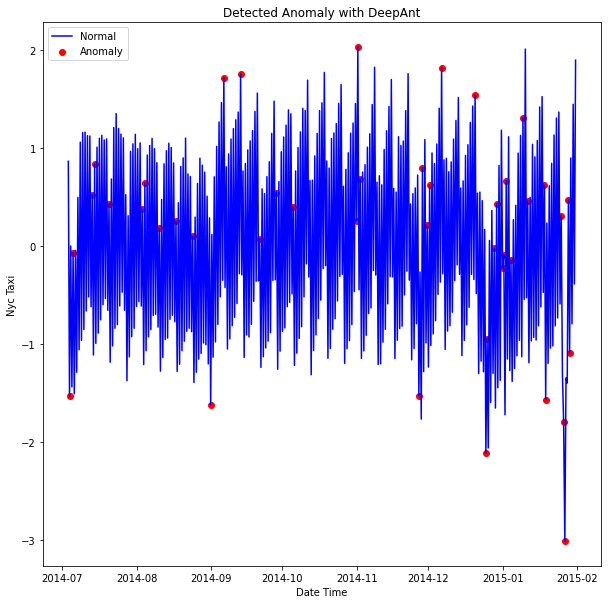

In [ ]:
y_pred = np.concatenate(predictions, axis=0)
sum_up_anomaly(get_anomaly_deepant, nyc_taxi[5:], 'Nyc Taxi',  'DeepAnt', y_pred, y)

In [ ]:
X, y, _ = make_dataset(temp_fail, ['value'], 5, 1, scale=True)

In [ ]:
split_indices = np.arange(0, len(X)+1, int(len(X)/5))
if split_indices[-1] != len(X):
  split_indices[-1] = len(X)
train_split = list()
test_split = list()
indices_total = np.arange(0, len(X))
for i in range(len(split_indices)-1):
  start, end = split_indices[i], split_indices[i+1]
  indices_test = list(np.arange(start, end))
  indices_train = list(set(indices_total) - set(indices_test))
  xtrain = X[indices_train]
  xtest = X[indices_test]
  ytrain = y[indices_train]
  ytest = y[indices_test]
  train_split.append((xtrain, ytrain))
  test_split.append((xtest, ytest))

In [ ]:
predictions = []
for train, test in zip(train_split, test_split):
  X_train, y_train = train
  X_test, y_test = test
  train_data = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
  test_data = TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))
  train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
  model = DeepAntModel(5, 1, True)
  model.cuda()
  loss = nn.MSELoss()
  optimizer = SGD(model.parameters(), lr=0.05)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.7)
  trainer = DeepAntTrainer(model, optimizer, scheduler, loss, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
  trainer.fit(100, train_loader, test_loader)
  y_pred = trainer.predict(test_loader, y_test.shape[0], 16)
  predictions.append(y_pred)

Epoch [1/100], TrainLoss: 0.8562, TestLoss: 1.1430, Learning rate = 0.05
Epoch [11/100], TrainLoss: 0.4147, TestLoss: 0.6111, Learning rate = 0.05
Epoch [21/100], TrainLoss: 0.3761, TestLoss: 0.7106, Learning rate = 0.05
Epoch [31/100], TrainLoss: 0.2744, TestLoss: 0.8495, Learning rate = 0.034999999999999996
Epoch [41/100], TrainLoss: 0.2799, TestLoss: 0.8276, Learning rate = 0.01715
Epoch [51/100], TrainLoss: 0.2556, TestLoss: 0.8477, Learning rate = 0.012004999999999998
Epoch [61/100], TrainLoss: 0.2312, TestLoss: 0.8604, Learning rate = 0.008403499999999998
Epoch [71/100], TrainLoss: 0.2350, TestLoss: 0.9060, Learning rate = 0.005882449999999998
Epoch [81/100], TrainLoss: 0.2659, TestLoss: 0.9178, Learning rate = 0.004117714999999998
Epoch [91/100], TrainLoss: 0.2315, TestLoss: 0.8956, Learning rate = 0.0028824004999999987
Epoch [1/100], TrainLoss: 1.1313, TestLoss: 0.2822, Learning rate = 0.05
Epoch [11/100], TrainLoss: 0.5046, TestLoss: 0.1933, Learning rate = 0.05
Epoch [21/100]

For Temperature Failure : F1 Score = 0.41935483870967744


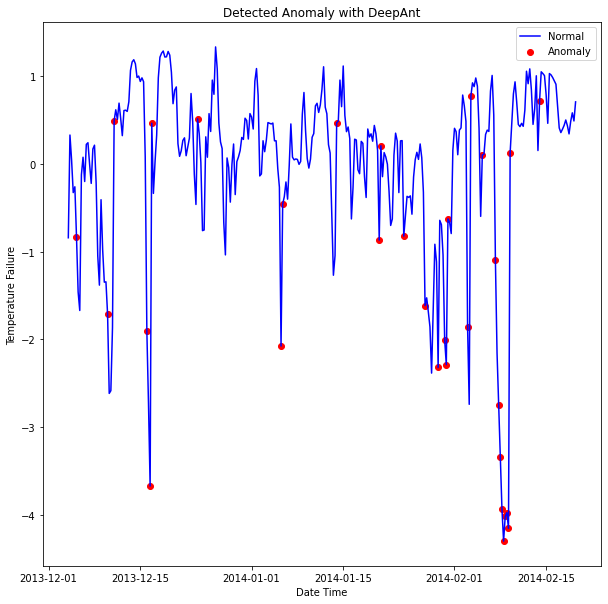

In [ ]:
y_pred = np.concatenate(predictions, axis=0)
sum_up_anomaly(get_anomaly_deepant, temp_fail[5:], 'Temperature Failure',  'DeepAnt', y_pred, y)